In [ ]:
pip install squarify

In [ ]:
from typing_extensions import dataclass_transform
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
data = pd.read_excel('ecommerce retail.xlsx', sheet_name=None)
df = data['ecommerce retail']
print(df.head())
seg = data['Segmentation']
seg.columns = ['Segment', 'RFM_Score']
print(seg.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
              Segment                                          RFM_Score
0           Champions                  555, 554, 544, 545, 454, 455, 445
1               Loyal             543, 444,

In [ ]:
df.info()
df.describe()
duplicates = df.duplicated()
print(df[duplicates])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
       InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539     

- Cột description và cột customer ID có giá trị null. Cột description không ảnh hưởng đến việc phân loại khách hàng nên có thể xoá cột này. Các dòng customer ID bị null sẽ ảnh hưởng đến kết quả phân loại khách hàng -> Xoá các dòng customer ID bị null
- Cột customerID có kiểu dữ liệu là float -> Chuyển thành string vì cột này không cần sử dụng để tính toán
- Giá trị nhỏ nhất của quantity là số âm -> Các giá trị âm có ảnh hưởng đến tính chỉ số M -> Xoá các giá trị quantity âm đi
- Một số customer ID bị duplicate -> Không xoá đi vì 1 khách hàng có thể mua hàng nhiều lần

In [ ]:
transaction = df.drop('Description', axis=1)
transaction = df.dropna(subset=['CustomerID'])
transaction = transaction.drop('Description', axis=1)
transaction['CustomerID'] = transaction['CustomerID'].astype(str)
transaction = transaction.query('Quantity >= 0')

print(transaction.info())
print(transaction.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Quantity     397924 non-null  int64         
 3   InvoiceDate  397924 non-null  datetime64[ns]
 4   UnitPrice    397924 non-null  float64       
 5   CustomerID   397924 non-null  object        
 6   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 24.3+ MB
None
            Quantity                    InvoiceDate      UnitPrice
count  397924.000000                         397924  397924.000000
mean       13.021823  2011-07-10 23:43:36.912475648       3.116174
min         1.000000            2010-12-01 08:26:00       0.000000
25%         2.000000            2011-04-07 11:12:00       1.250000
50%         6.000000   

In [ ]:
# Tính Recency
max_purchase= transaction.groupby('CustomerID')['InvoiceDate'].max().reset_index()
max_purchase.columns = ['CustomerID', 'LastPurchaseDate']
max_purchase['LastPurchaseDate'].max()
max_purchase['Recency'] = (max_purchase['LastPurchaseDate'].max() - max_purchase['LastPurchaseDate']).dt.days
user = pd.DataFrame(transaction['CustomerID'].unique())
user.columns = ['CustomerID']
user = pd.merge(user, max_purchase[['CustomerID','Recency']], on='CustomerID', how='inner')
print(user)



     CustomerID  Recency
0       17850.0      371
1       13047.0       31
2       12583.0        2
3       13748.0       95
4       15100.0      333
...         ...      ...
4334    13436.0        1
4335    15520.0        1
4336    13298.0        0
4337    14569.0        0
4338    12713.0        0

[4339 rows x 2 columns]


In [ ]:
# Tinh Frequency
frequency = transaction.groupby('CustomerID')['InvoiceDate'].count().reset_index()
user = pd.merge(user, frequency, on='CustomerID', how='inner')
user.columns = ['CustomerID', 'Recency', 'Frequency']
print(user)

     CustomerID  Recency  Frequency
0       17850.0      371        297
1       13047.0       31        172
2       12583.0        2        247
3       13748.0       95         28
4       15100.0      333          3
...         ...      ...        ...
4334    13436.0        1         12
4335    15520.0        1         18
4336    13298.0        0          2
4337    14569.0        0         12
4338    12713.0        0         38

[4339 rows x 3 columns]


In [ ]:
#Tính Monetary
transaction['Revenue'] = transaction['Quantity'] * transaction['UnitPrice']
revenue = transaction.groupby('CustomerID')['Revenue'].sum().reset_index()
user = pd.merge(user, revenue, on='CustomerID')
user.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(user)

     CustomerID  Recency  Frequency  Monetary
0       17850.0      371        297   5391.21
1       13047.0       31        172   3237.54
2       12583.0        2        247   7281.38
3       13748.0       95         28    948.25
4       15100.0      333          3    876.00
...         ...      ...        ...       ...
4334    13436.0        1         12    196.89
4335    15520.0        1         18    343.50
4336    13298.0        0          2    360.00
4337    14569.0        0         12    227.39
4338    12713.0        0         38    848.55

[4339 rows x 4 columns]


In [ ]:
user['R_score'] = pd.qcut(user['Recency'], 5, labels=[5, 4, 3, 2, 1])
user['F_score'] = pd.qcut(user['Frequency'], 5, labels=[1, 2, 3, 4, 5])
user['M_score'] = pd.qcut(user['Monetary'], 5, labels=[1, 2, 3, 4, 5])
user['RFM_Score'] = user['R_score'].astype(str) + user['F_score'].astype(str) + user['M_score'].astype(str)

seg['RFM_Score'] = seg['RFM_Score'].str.split(',')
seg = seg.explode('RFM_Score').reset_index(drop=True)
seg['RFM_Score'] = seg['RFM_Score'].str.strip()
seg = pd.merge(user, seg, on='RFM_Score', how='left')
# In kết quả
print(seg.head())




  CustomerID  Recency  Frequency  Monetary R_score F_score M_score RFM_Score  \
0    17850.0      371        297   5391.21       1       5       5       155   
1    13047.0       31        172   3237.54       4       5       5       455   
2    12583.0        2        247   7281.38       5       5       5       555   
3    13748.0       95         28    948.25       2       2       4       224   
4    15100.0      333          3    876.00       1       1       3       113   

            Segment  
0  Cannot Lose Them  
1         Champions  
2         Champions  
3           At Risk  
4  Cannot Lose Them  


<ipython-input-61-34bc91f9dd78>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seg[col])


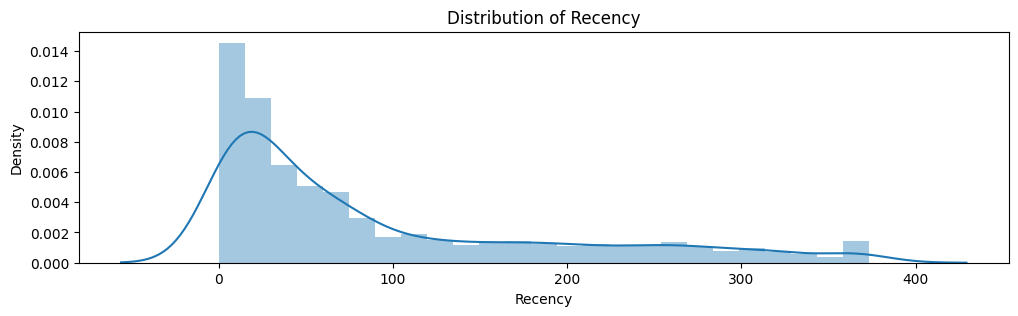

<ipython-input-61-34bc91f9dd78>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seg[col])


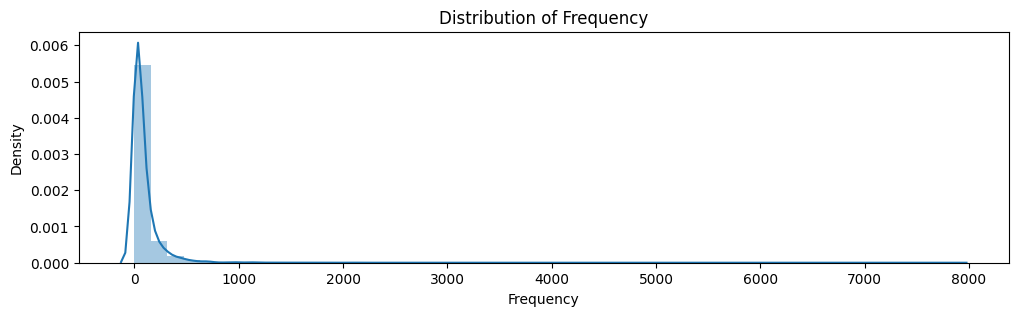

<ipython-input-61-34bc91f9dd78>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seg[col])


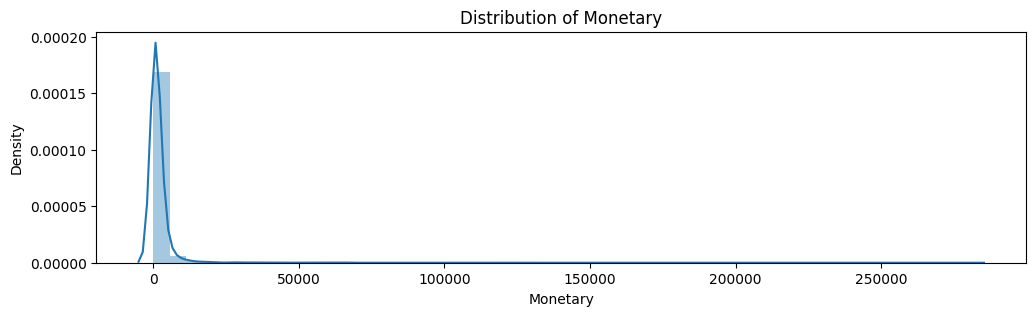

In [ ]:
colnames = ['Recency', 'Frequency', 'Monetary']
for col in colnames:
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.distplot(seg[col])
    ax.set_title('Distribution of %s' %col)
    plt.show()

In [ ]:
segment = seg.groupby('Segment').agg(
    Number_of_Customers=('CustomerID', 'count'),
    Sales_num=('Monetary', 'sum')
    )
segment['Segment'] = segment.index
total_customers = segment['Number_of_Customers'].sum()
Total_sales =seg['Monetary'].sum()
segment['Count_share'] = segment['Number_of_Customers'] / total_customers
segment['Sales_share'] = segment['Sales_num'] / Total_sales
segment.columns = ['Number_of_Customers', 'Sales_num', 'Segment', 'Count_share', 'Sales_share']
print(segment)


                       Number_of_Customers    Sales_num  \
Segment                                                   
About To Sleep                         185    53268.290   
At Risk                                418   636320.170   
Cannot Lose Them                        90   298471.111   
Champions                              807  5496673.110   
Hibernating customers                  795   321467.042   
Lost customers                         434    77817.240   
Loyal                                  413   989182.830   
Need Attention                         230   343127.240   
New Customers                          314    65750.910   
Potential Loyalist                     515   301536.471   
Promising                              138   327793.490   

                                     Segment  Count_share  Sales_share  
Segment                                                                 
About To Sleep                About To Sleep     0.042637     0.005978  
At Risk      

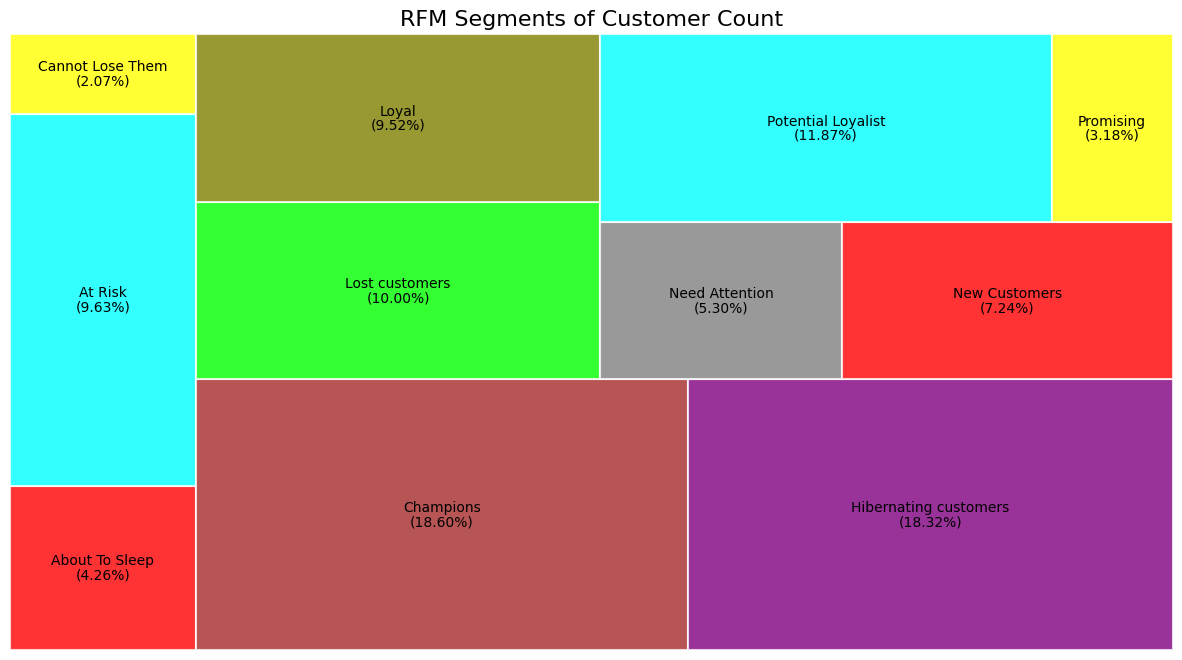

In [ ]:
colors = ['#FF0000', '#00FFFF', '#FFFF00', '#A52A2A', '#800080', '#00FF00', '#808000', '#808080']

fig, ax = plt.subplots(1, figsize=(15, 8))

squarify.plot(sizes=segment['Number_of_Customers'],
              label=segment['Segment'],
              value=[f'({x*100:.2f}%)' for x in segment['Count_share']],
              alpha=.8,
              color=colors,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white"))

plt.title('RFM Segments of Customer Count', fontsize=16)
plt.axis('off')
plt.show()

In [ ]:
print(segment.shape)

(11, 2)


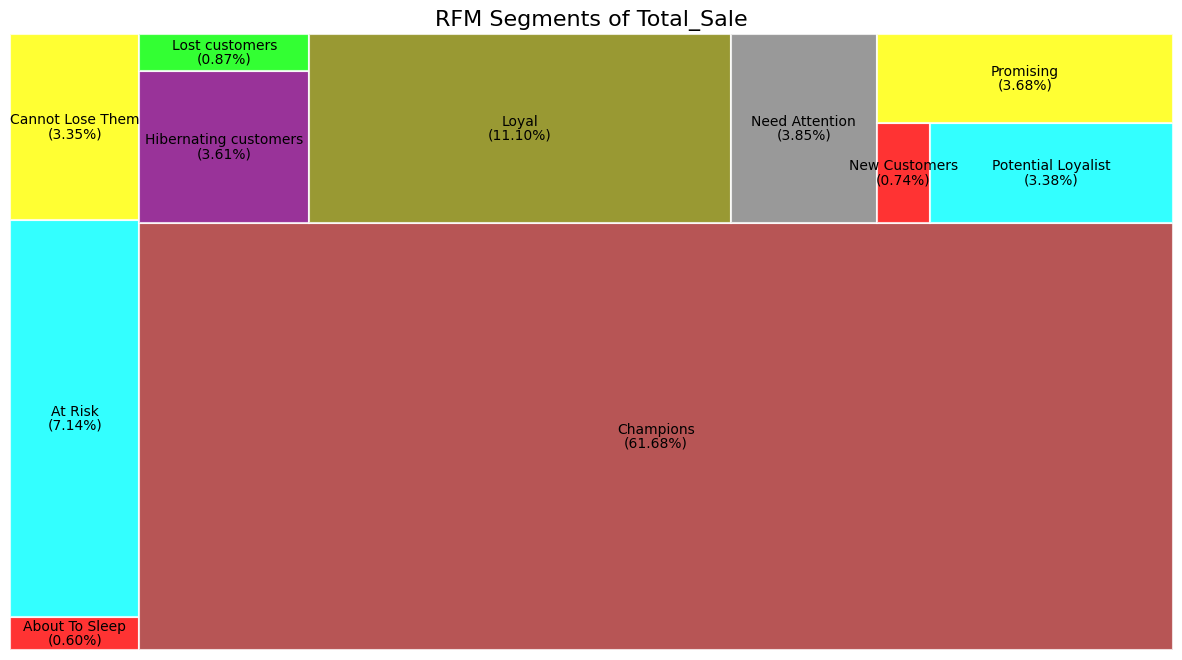

In [ ]:
colors = ['#FF0000', '#00FFFF', '#FFFF00', '#A52A2A', '#800080', '#00FF00', '#808000', '#808080']

fig, ax = plt.subplots(1, figsize=(15, 8))

squarify.plot(sizes=segment['Sales_num'],
              label=segment['Segment'],
              value=[f'({x*100:.2f}%)' for x in segment['Sales_share']],
              alpha=.8,
              color=colors,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white"))

plt.title('RFM Segments of Total_Sale', fontsize=16)
plt.axis('off')
plt.show()